<a href="https://colab.research.google.com/github/lqiang67/generative_models_examples/blob/main/mmd_gan_2D_toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

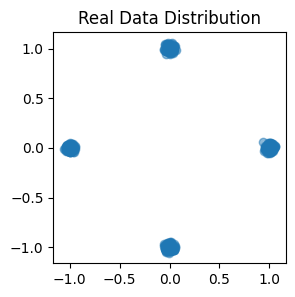

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# MLP
class MLP(nn.Module):
    def __init__(self, layer_sizes, activation=nn.ReLU, linear_layer=nn.Linear):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        self.linear_layer = linear_layer
        for i in range(len(layer_sizes) - 1):
            self.layers.append(self.linear_layer(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:  # No activation after the last layer
                self.layers.append(self.activation())

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x

# Define the 2D Toy Dataset
def sample_gmm(batch_size, num_modes=4, std=0.02):
    centers = torch.tensor([[1, 0], [-1, 0], [0, 1], [0, -1]], dtype=torch.float32)
    centers = centers[:num_modes]

    batch_data = []
    for _ in range(batch_size):
        center = centers[torch.randint(0, len(centers), (1,)).item()]
        point = center + torch.randn_like(center) * std
        batch_data.append(point)

    return torch.stack(batch_data)

# Visualize the data
data_points = sample_gmm(1000)
plt.figure(figsize=(3,3))
plt.scatter(data_points[:, 0], data_points[:, 1], alpha=0.5)
plt.title('Real Data Distribution')
plt.show()



In [25]:
#@title Distances

def kernel_mmd(x, y, kernel='rbf', bandwidth = -1):
    """Compute the MMD distance between two datasets x and y."""
    #https://en.wikipedia.org/wiki/Kernel_embedding_of_distributions#Measuring_distance_between_distributions

    xx, yy, xy = x @ x.t(), y @ y.t(), x @ y.t()
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2*xx
    dyy = ry.t() + ry - 2*yy
    dxy = rx.t() + ry - 2*xy

    if kernel == 'rbf':
        if bandwidth<0:
          scale = -bandwidth * (dxy.median().detach())
        else:
          scale = bandwidth
        Kxx = torch.exp(-dxx / scale)
        Kyy = torch.exp(-dyy / scale)
        Kxy = torch.exp(-dxy / scale)
    else:
        raise NotImplementedError

    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()


def energy_distance(x, y, p=1, eps = 1e-6):
    """Compute the energy distance between two datasets x and y."""
    #https://en.wikipedia.org/wiki/Energy_distance
    xx, yy, xy = x @ x.t(), y @ y.t(), x @ y.t()
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2*xx
    dyy = ry.t() + ry - 2*yy
    dxy = rx.t() + ry - 2*xy

    return 2 * (dxy+eps).pow(p/2).mean() - (dxx+eps).pow(p/2).mean() - (dyy+eps).pow(p/2).mean()


x = torch.randn(100, 2)
y = torch.randn(100, 2)
dist = kernel_mmd(x,y)
print(dist)
dist = energy_distance(x,y)
print(dist)

tensor(0.0145)
tensor(0.0480)


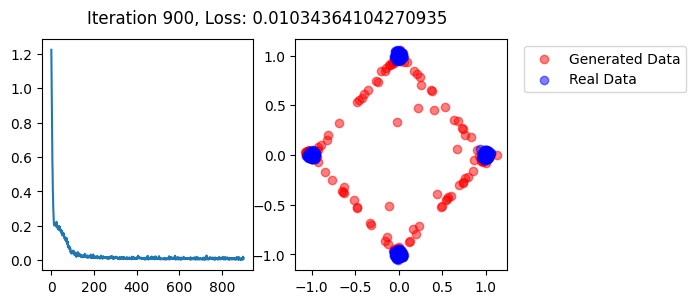

In [26]:
#@title Training
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


noise_dim = data_dim = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = MLP([noise_dim, 128,128, 128, data_dim]).to(device)
generator.sample = lambda num_samples: generator(torch.randn(num_samples, noise_dim).to(device))
optimizer = optim.Adam(generator.parameters(), lr=1e-3)
batch_size = 256

loss_curve = []
for iter in range(1000):

    optimizer.zero_grad()

    # data batch
    real_data = data_points[torch.randperm(data_points.shape[0])[:batch_size]].to(device)
    fake_data = generator.sample(batch_size)

    loss = kernel_mmd(real_data, fake_data, bandwidth = .1)
    #loss = energy_distance(real_data, fake_data, p = 1)

    loss.backward()
    optimizer.step()
    loss_curve.append(loss.item())

    if iter % 100 == 0:
        clear_output(wait=True)

        plt.figure(figsize=(2*3, 3))

        plt.subplot(1, 2, 1)
        plt.plot(loss_curve)

        plt.subplot(1, 2, 2)
        generated_data = generator.sample(data_points.shape[0]).detach().cpu().numpy()
        plt.scatter(generated_data[:, 0], generated_data[:, 1], alpha=0.5, color='red', label='Generated Data')
        plt.scatter(data_points[:, 0], data_points[:, 1], alpha=0.5, color='blue', label='Real Data')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.suptitle(f"Iteration {iter}, Loss: {loss.item()}")
        plt.show()

